### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib
Processing...
Done!


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [172]:
import copy

def binarize(X):
    # YOUR CODE HERE
    X_bin = copy.copy(X)
    X_bin = X_bin / 255.0
    X_bin = (X_bin > 1.0/2).astype(np.float_)
    return X_bin

bin_train_data = binarize(train_data)
print (bin_train_data.shape)
print (train_data.shape)

(60000, 784)
(60000, 784)


In [173]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

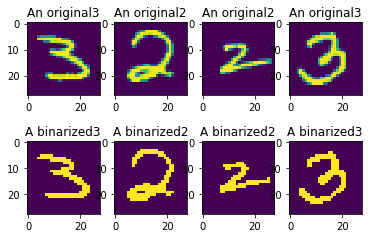

In [174]:
# YOUR CODE HERE
from random import choices
list_of_idx = choices([i for i,label in enumerate(train_labels) if label == 2 or label == 3 or label == 4], k=4)

for i in range(1,5):
    plt.subplot(int(str(24)+str(i)))
    plt.imshow(train_data[list_of_idx[i-1]].reshape(28,28))
    plt.title('An original'+str(train_labels[list_of_idx[i-1]]))
    
for i in range(5,9):
    plt.subplot(int(str(24)+str(i)))
    plt.imshow(bin_train_data[list_of_idx[i-5]].reshape(28,28))    
    plt.title('A binarized'+str(train_labels[list_of_idx[i-5]]))


### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [187]:
from scipy.special import logsumexp

def E_step(X, mu, pi):
    # YOUR CODE HERE
    eps = 1e-10

    enum = np.dot(X,np.log(mu+eps).T) + np.dot(1.0-X,np.log(1.0-mu+eps).T) + np.log(pi)
    
    denum = logsumexp(enum,axis=1,keepdims = True)
    
    gamma = np.exp(enum-denum)
    
    return gamma

In [188]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [189]:
def M_step(X, gamma):
    # YOUR CODE HERE
    N_k = np.sum(gamma,axis=0,keepdims=True)
    pi = N_k / X.shape[0]

    mu = np.dot(gamma.T,X) 
    
    mu = mu / N_k.T

    return mu, np.squeeze(pi)

In [190]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [379]:
def EM(X, K, max_iter, mu=None, pi=None,verbose=True):
    # YOUR CODE HERE
    
    # Initialize mu and pi first, if necessary:
    if not np.any(mu):
        mu = np.random.uniform(low=.25, high=.75, size=(K,X.shape[1]))
    if not np.any(pi):
        pi = np.ones(K) / K
        
    conv_limit = 1e-7
        
    for e in range(0,max_iter):
        
        if e % 10 == 0 and verbose:
            print ('At epoch',e,'of',max_iter)
        
        # Make a copy
        old_mu = copy.copy(mu)
        
        gamma = E_step(X, mu, pi) 
        mu, pi = M_step(X, gamma)
        
        if np.sum(old_mu-mu) < conv_limit:
            if verbose:
                print ('Converged after',e,'epochs')
            break
    
    return mu,pi,gamma
        

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [263]:
# YOUR CODE HERE
from collections import Counter
def create_new_training_set(X,y):
    
    counts = Counter(y)
    true_dis = [counts[i] for i in [2,3,4]]
    true_dis = true_dis / sum(true_dis)
    
    # Select indices of elements with label 2,3 or 4
    list_of_idx = [i for i,label in enumerate(y) if label in [2,3,4]]
    
    new_X = [X[i] for i in list_of_idx]
    new_y = [y[i] for i in list_of_idx]
    
    assert len(new_X) == len(new_y)
            
    new_X, new_y = np.stack(new_X), np.stack(new_y)
    new_X = binarize(new_X)
    return new_X, new_y, true_dis

new_x,new_y,true_dis = create_new_training_set(train_data,train_labels)

At epoch 0 of 100
At epoch 10 of 100
At epoch 20 of 100
At epoch 30 of 100
At epoch 40 of 100
At epoch 50 of 100
Converged after 50 epochs
True mixing coefficients, for 2, 3 and 4 (in that order)!
[0.33227372 0.34192181 0.32580447]

Mixing coefficients for the reconstructed images:
[0.31833787 0.34835551 0.33330661]


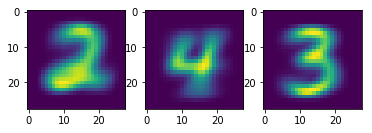

In [289]:
mu,pi,gamma = EM(new_x, 3, 100, mu=None, pi=None)
print ('True mixing coefficients, for 2, 3 and 4 (in that order)!')
print (true_dis)
print ('')
print ('Mixing coefficients for the reconstructed images:')
print (pi)

for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(13)+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

The reconstructed digits represent 2,4,3 from left to right. The mixing coefficients are printed above the reconstructed digits. They are quite close to the true values. 

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

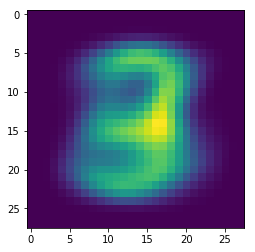

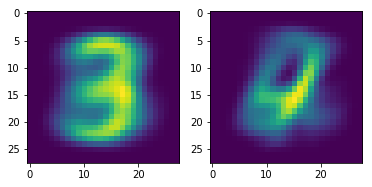

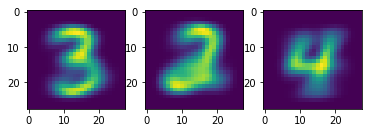

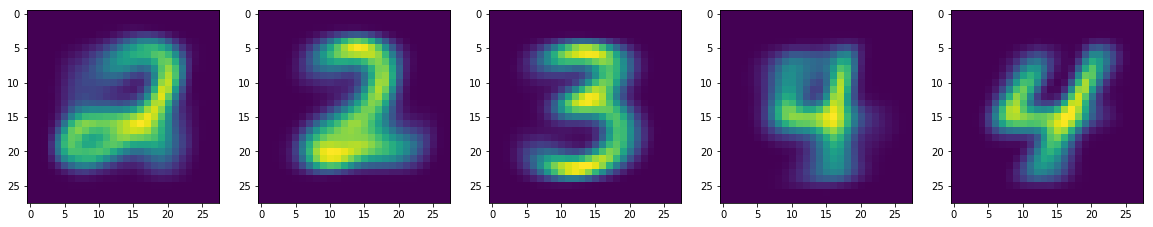

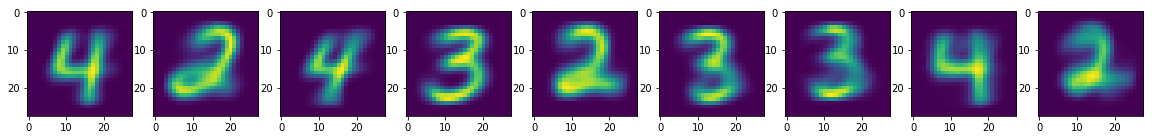

In [338]:
# YOUR CODE HERE

plt.figure(1)
mu,pi,_ = EM(new_x, 1, 100, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

plt.figure(2)
mu,pi,_ = EM(new_x, 2, 100, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

plt.figure(3)
mu,pi,_ = EM(new_x, 3, 150, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))
    
plt.figure(4,figsize=(20,20))
mu,pi,_ = EM(new_x, 5, 150, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

plt.figure(5,figsize=(20,20))
mu,pi,_ = EM(new_x, 9, 150, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))


We ran the algorithm with 1, 2, 3, 5 and 9 classes and printed the results. With one class, the reconstructed digit looks blurry, and it is hard to classify as a digit. With two classes we can already see the a 3, and something that represents a mixture of a 2 and a 4. With three classes we can clearly see the 4,3 and 2. With five classes we can see two different types of 4s (one is slanted, the other straight) and two different types of 2s and one type of 4. With 9 classes we can distinguish 3 different types of 2s (the main difference is the curl in the lower left corner), three different types of 3s and thee different types of 4s. Note that running the code cell above will produce different results, it is not deterministic. 

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

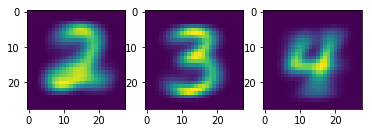

In [298]:
# YOUR CODE HERE

# Rerun with 3 classes first
mu,pi,gamma = EM(new_x, 3, 150, mu=None, pi=None,verbose=False)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

9.536556801070772 % of images is misclassified
Counter({2: 872, 3: 758, 4: 80})


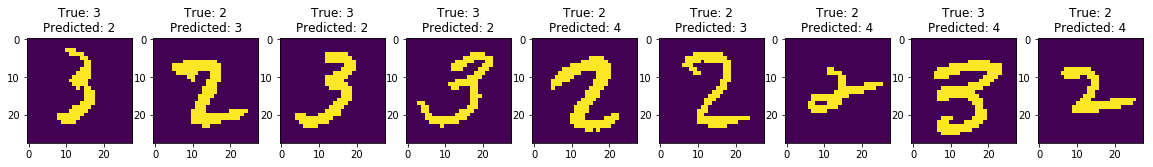

In [347]:
from random import choices
from collections import Counter

order = [2,3,4]
y_pred = np.argmax(gamma,axis=1)

misclassified_idx = [idx for idx,label in enumerate(new_y) if label != order[y_pred[idx]]]
selection = choices(misclassified_idx,k=9)

figure(1,figsize=(20,20))
for i, idx in enumerate(selection):
    plt.subplot(int(str(1)+str(len(selection))+str(i+1)))
    plt.imshow(new_x[idx].reshape(28,28),aspect='equal')
    plt.title('True: '+str(new_y[idx])+'\n'+'Predicted: '+str(order[y_pred[idx]]))

print (100*len(misclassified_idx)/len(new_y),'% of images is misclassified')

misclassified_label = [label for idx,label in enumerate(new_y) if label != order[y_pred[idx]]]
misclassified_counts = Counter(misclassified_label)
print (misclassified_counts)

It appears that the 2 and 3 are misclassified 10 times more than the 4s. This could be because 4s have a distinctive shape compared to a 2 and a 3. A 2 and a 3 look quite similar, they have a curly top, and if you draw them fast and messy they look quite alike. This is the reason we have misclassified so many 2s and 3s. 

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

True mixing coefficients: [0.33227372 0.34192181 0.32580447]


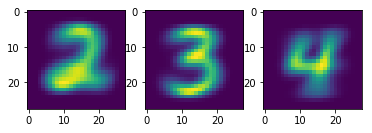

In [383]:
# YOUR CODE HERE
pi_true = np.array(true_dis)

two_idx = np.stack([new_x[idx] for idx,i in enumerate(new_y) if i == 2])
three_idx = np.stack([new_x[idx] for idx,i in enumerate(new_y) if i == 3])
four_idx = np.stack([new_x[idx] for idx,i in enumerate(new_y) if i == 4])

two_idx = np.mean(two_idx,axis=0).reshape(1,784)
three_idx = np.mean(three_idx,axis=0).reshape(1,784)
four_idx = np.mean(four_idx,axis=0).reshape(1,784)

mu_true = np.vstack((two_idx,three_idx,four_idx))

for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

print ('True mixing coefficients:',pi_true)

At epoch 0 of 150
Converged after 0 epochs
Predicted mixing coefficients: [0.32725753 0.33232302 0.34041945]


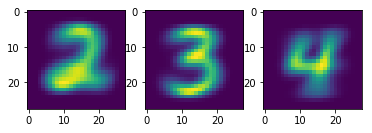

In [384]:
mu,pi,gamma = EM(new_x, 3, 150, mu=mu_true, pi=pi_true,verbose=True)
for i in range(1,mu.shape[0]+1):
    plt.subplot(int(str(1)+str(mu.shape[0])+str(i)))
    plt.imshow(mu[i-1,:].reshape(28,28))

print ('Predicted mixing coefficients:',pi)

One would expect that in the case of initaliaztion with the true values of the parameters, it would converge after 0 (or 1) epochs and retrieved mixing coefficients would be equal to the true mixing coefficients. This is the case, however the mixing coefficients and mu-matrix are updated because regardless of initialization, the algorithm is run for 1 iteration. 

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

In [3]:
# Some functions we use before getting to the training bit:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional
from matplotlib import pyplot as plt

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [4]:
def log_bernoulli_loss(x_hat, x):
    return -torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))

In [5]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

$$KL(q(\mathbf{z})||p(\mathbf{z})) = - \frac{1}{2}\sum_{i=1}^N 1 + \log\sigma_i^2 + \mu_i^2 + \sigma_i^2$$

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [6]:
def KL_loss(mu, logvar):
    return torch.sum(mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)).mul_(-0.5)

In [7]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [8]:
def loss_function(x_hat, x, mu, logvar):
    return log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)


In [9]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [10]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [11]:
def encode(self, x):
    
    x = self.fc1(x)
    x = F.sigmoid(x)
    mu, logvar = self.fc21(x), self.fc22(x)
    
    return mu, logvar


In [12]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [13]:
def reparameterize(self, mu, logvar):
    
    # std = exp(log_variance / 2)
    std = logvar.mul(0.5).exp_()
    
    # Random normal vector depending on std size
    epsilon = torch.FloatTensor(std.size()).normal_()

    sample = mu + std * epsilon
    return sample


In [14]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [15]:
def decode(self, z):
    
    x_hat = self.fc3(z)
    x_hat = F.relu(x_hat)
    x_hat = self.fc4(x_hat)
    x_hat = F.sigmoid(x_hat)
    
    return x_hat

In [16]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [17]:
def forward(self, x):
    x = x.view(-1, 784)
    
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [18]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [19]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [50]:
# Hyperparameters
fc1_dims = (784, 256)
fc21_dims = (256, 20)
fc22_dims = (256, 20)
fc3_dims = (20, 256)
fc4_dims = (256, 784)
lr = 0.001
batch_size = 50
epochs = 10


In [51]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [52]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.746155
Train Epoch: 1 [5000/60000 (8%)]	Loss: 206.367737
Train Epoch: 1 [10000/60000 (17%)]	Loss: 185.313873
Train Epoch: 1 [15000/60000 (25%)]	Loss: 156.478149
Train Epoch: 1 [20000/60000 (33%)]	Loss: 155.390610
Train Epoch: 1 [25000/60000 (42%)]	Loss: 153.914108
Train Epoch: 1 [30000/60000 (50%)]	Loss: 143.822021
Train Epoch: 1 [35000/60000 (58%)]	Loss: 141.310425
Train Epoch: 1 [40000/60000 (67%)]	Loss: 137.018463
Train Epoch: 1 [45000/60000 (75%)]	Loss: 132.492584
Train Epoch: 1 [50000/60000 (83%)]	Loss: 131.733109
Train Epoch: 1 [55000/60000 (92%)]	Loss: 116.525948
====> Epoch: 1 Average loss: 155.5951
Train Epoch: 2 [0/60000 (0%)]	Loss: 122.209625
Train Epoch: 2 [5000/60000 (8%)]	Loss: 119.419510
Train Epoch: 2 [10000/60000 (17%)]	Loss: 129.491119
Train Epoch: 2 [15000/60000 (25%)]	Loss: 131.496338
Train Epoch: 2 [20000/60000 (33%)]	Loss: 119.996155
Train Epoch: 2 [25000/60000 (42%)]	Loss: 120.081467
Train Epoch: 2 [30000/60000 (50%)]	Loss:

Run the box below to check if the model you trained above is able to correctly reconstruct images.

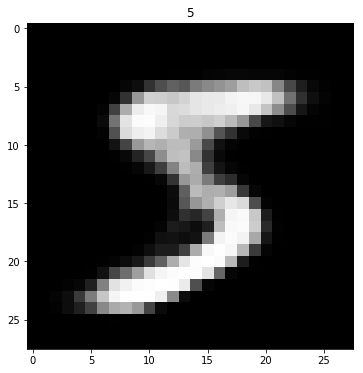

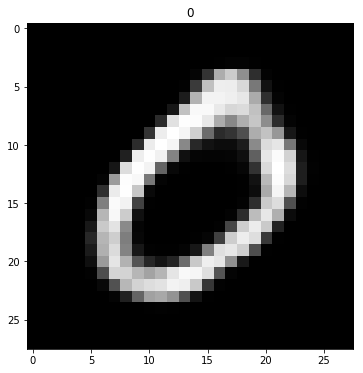

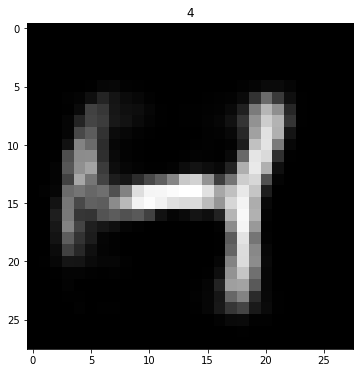

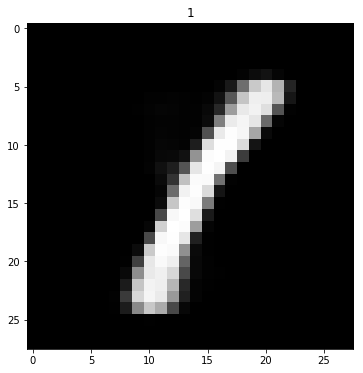

In [53]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [43]:
# Hyperparameters for visualization:
fc1_dims = (784, 256)
fc21_dims = (256, 2)
fc22_dims = (256, 2)
fc3_dims = (2, 256)
fc4_dims = (256, 784)
lr = 0.001
batch_size = 50
epochs = 5

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 551.369629
Train Epoch: 1 [5000/60000 (8%)]	Loss: 210.054871
Train Epoch: 1 [10000/60000 (17%)]	Loss: 194.508423
Train Epoch: 1 [15000/60000 (25%)]	Loss: 185.016739
Train Epoch: 1 [20000/60000 (33%)]	Loss: 185.526779
Train Epoch: 1 [25000/60000 (42%)]	Loss: 164.586121
Train Epoch: 1 [30000/60000 (50%)]	Loss: 177.507141
Train Epoch: 1 [35000/60000 (58%)]	Loss: 168.549088
Train Epoch: 1 [40000/60000 (67%)]	Loss: 172.997742
Train Epoch: 1 [45000/60000 (75%)]	Loss: 187.018555
Train Epoch: 1 [50000/60000 (83%)]	Loss: 181.307617
Train Epoch: 1 [55000/60000 (92%)]	Loss: 173.684555
====> Epoch: 1 Average loss: 183.4013
Train Epoch: 2 [0/60000 (0%)]	Loss: 164.900833
Train Epoch: 2 [5000/60000 (8%)]	Loss: 166.781586
Train Epoch: 2 [10000/60000 (17%)]	Loss: 170.216080
Train Epoch: 2 [15000/60000 (25%)]	Loss: 158.933640
Train Epoch: 2 [20000/60000 (33%)]	Loss: 173.336517
Train Epoch: 2 [25000/60000 (42%)]	Loss: 171.158081
Train Epoch: 2 [30000/60000 (50%)]	Loss:

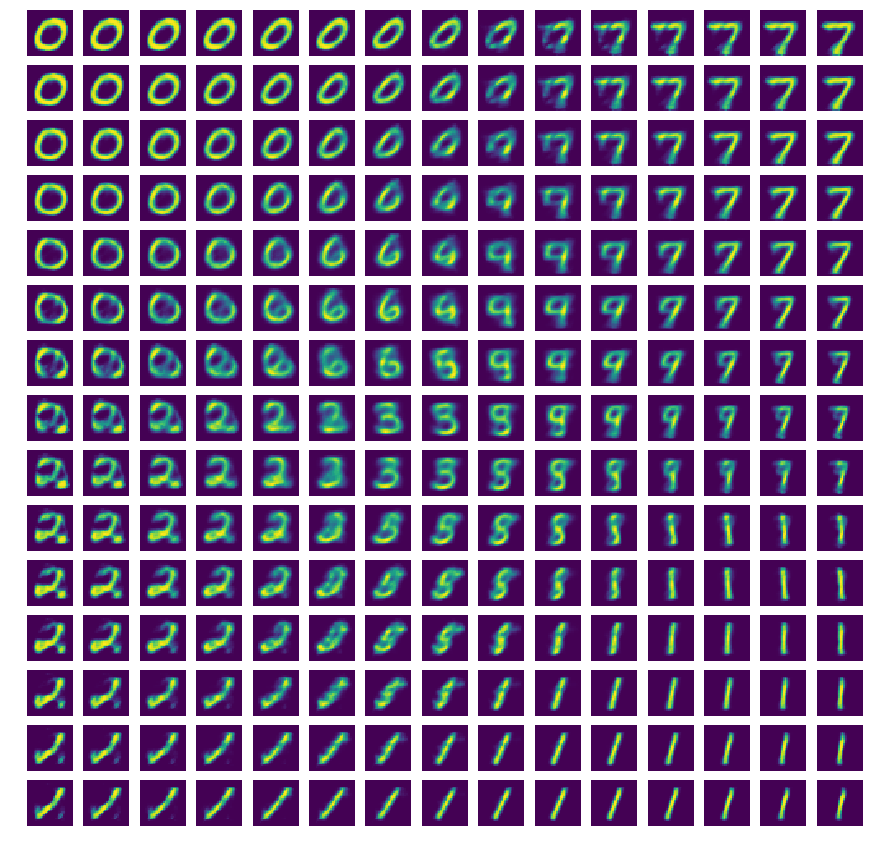

In [49]:
plt.rcParams['figure.figsize'] = [15, 15]

n_images = 15

X = np.linspace(-3, 3, n_images)
Y = np.linspace(-3, 3, n_images)

fig, ax = plt.subplots(n_images, n_images)

for xi, i in enumerate(X):
    for yi, j in enumerate(Y):
        
        # Feed vector into the network latent space:
        z_sample = torch.FloatTensor([i, j]).unsqueeze(0)
        
        # Decode latent vector:
        x_sample = VAE_MNIST.decode(z_sample).data.numpy()
        
        # Plot:

        ax[xi, yi].imshow(x_sample.reshape(28, -1))
        ax[xi, yi].axis('off')

plt.show()
plt.rcParams['figure.figsize'] = [6, 6]

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


The naive non-amortized method of performing inference in Variational Autoencoders would be to propose a variational distribution $q_n(\mathbf{z})$ for each observation $\mathbf{x}_n$. A consequence of this is that the number of parameters to learn would grow equally with the number of observations. As the MNIST dataset contains 60000 training observations, this is not optimal nor would one easily infer $\mathbf{z}$ given a previously unseen $\mathbf{x}_n$, as for each $\mathbf{x}_n$, we have a tailored $q_n(\mathbf{z})$. Therefore, we need a model $q(\mathbf{z}_n|\mathbf{x}_n, \mathbf{\theta})$, where $\mathbf{\theta}$ encompasses the set of parameters that is shared across all observations. This is called amortized inference (thus the benefit of amortization is that it one do not have to to estimate 60000 parameters, in our case). The encoder ensures this amortizing property by generating the mean and log variance given the embedded input.